In [1]:
import pymc4 as pm
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [11]:
config = tf.ConfigProto()
config.graph_options.optimizer_options.global_jit_level = (
    tf.OptimizerOptions.ON_1)
config.intra_op_parallelism_threads = 1
config.inter_op_parallelism_threads = 1
sess = tf.InteractiveSession(config=config)

# Linear Regression

In [3]:
# Logp calculation for linear regression 
@pm.model
def linreg(sd_prior='half_normal', n_points = 100):    
    # Define priors
    sigma = pm.HalfNormal('sigma', scale = 10)
    intercept = pm.Normal('Intercept', 0, scale=10)
    x_coeff = pm.Normal('weight', 0, scale = 5)
    x = np.linspace(-5, 5, n_points)
    
    # Define likelihood
    y = pm.Normal('y', loc=intercept + x_coeff * x, scale=sigma)
    
    
model = linreg.configure()

forward_sample = sess.run(model.forward_sample())

forward_sample

{'sigma': 9.688243,
 'Intercept': -9.532851,
 'weight': 4.7256627,
 'y': array([-35.108826  , -28.40461   , -22.609121  , -23.087639  ,
        -31.466806  , -31.609858  , -17.605282  , -40.187885  ,
        -27.662601  , -27.927702  , -30.923122  , -28.36731   ,
        -28.10574   , -18.792     , -21.435509  , -31.63293   ,
        -15.079545  , -31.091877  , -18.140463  , -20.501013  ,
        -32.79942   , -23.225908  , -26.049978  , -27.417809  ,
        -23.797089  , -19.058596  , -28.13646   , -18.55058   ,
        -16.493927  , -12.60777   ,  -7.627468  , -26.55682   ,
        -35.10599   , -20.94539   , -14.319589  ,   0.19192696,
        -12.7274    , -16.249945  , -16.512009  ,  -4.900056  ,
        -35.479908  , -16.745579  , -17.713486  , -21.229317  ,
        -14.710437  ,   2.3880844 , -21.003353  , -16.25414   ,
        -25.57706   , -22.204033  ,  -6.9885263 , -32.137924  ,
         -7.5981116 ,   5.198202  , -20.791328  ,  -8.199968  ,
         -1.5638452 ,  -4.243048

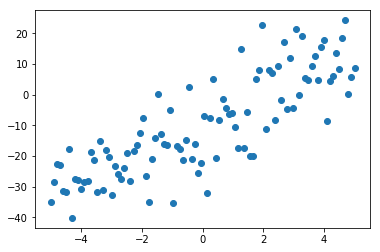

In [4]:
plt.scatter(np.linspace(-5, 5, 100), forward_sample['y'])

In [5]:
func = model.make_log_prob_function()
sigma = tf.placeholder(tf.float32)
intercept = tf.placeholder(tf.float32)
x_coeff = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32, shape=(100,))
logp = func(sigma, intercept, x_coeff, y)


In [6]:
feed_dict = {sigma: forward_sample['sigma'], 
            intercept: forward_sample['Intercept'], 
            x_coeff: forward_sample['weight'], 
            y: forward_sample['y']}

sess.run(logp, feed_dict=feed_dict)

-373.6918

In [44]:
import pymc3 as pm3

/anaconda3/envs/GSoC/lib/python3.6/subprocess.py:766: ResourceWarning: subprocess 39651 is still running
  ResourceWarning, source=self)
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/misc/cpucount.py:48: ResourceWarning: unclosed file <_io.TextIOWrapper name=57 encoding='UTF-8'>
  num = int(os.popen('sysctl -n hw.ncpu').read())
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/tests/main.py:6: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing.nosetester import NoseTester


In [8]:
n_points = 100
with pm3.Model() as model3: 
    # Define priors
    sigma = pm3.HalfNormal('sigma', sd = 10, observed=forward_sample['sigma'])
    intercept = pm3.Normal('Intercept', 0, 10, observed=forward_sample['Intercept'])
    x_coeff = pm3.Normal('weight', 0, 5, observed=forward_sample['weight'])
    x = np.linspace(-5, 5, n_points)
    
    # Define likelihood
    y = pm3.Normal('y', intercept + x_coeff * x, sigma, observed=forward_sample['y'])
    
model3.logp()

/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py:274: DeprecationWarning: SO is deprecated, use EXT_SUFFIX
  dist_suffix = distutils.sysconfig.get_config_var("SO")
/anaconda3/envs/GSoC/lib/python3.6/site-packages/theano/gof/cmodule.py

array(-373.69181035)

# Centered-Eight 

In [54]:
schools = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.])
sigma = tf.to_float(np.array([15., 10., 16., 11.,  9., 11., 10., 18.]))
n_points = 8

@pm.model
def centered_eight(n_points = n_points):    
    # Define priors
    mu = pm.Normal('mu', loc = 0, scale = 5)
    tau = pm.HalfCauchy('tau', loc = 0, scale = 5)
    theta = pm.Normal('theta', loc = tf.fill([8], mu.as_tensor()), scale = tf.fill([8], tau.as_tensor()))
    # Awkward syntax: Feature?
    
    # Define likelihood
    y = pm.Normal('y', loc = theta, scale = sigma)
    
model = centered_eight.configure()

forward_sample = sess.run(model.forward_sample())

forward_sample

{'mu': -4.9678407,
 'tau': 10.480726,
 'theta': array([  9.650578  ,  -9.475149  ,   1.8602962 , -10.215586  ,
        -26.623749  ,  -6.949975  ,  -0.69186926,   8.773672  ],
       dtype=float32),
 'y': array([ -3.061283 , -11.399759 , -16.881237 ,  -2.0607681, -25.413725 ,
        -18.368652 ,   3.9272532,  -8.401381 ], dtype=float32)}

In [55]:
func = model.make_log_prob_function()
mu = tf.placeholder(tf.float32)
tau = tf.placeholder(tf.float32)
theta = tf.placeholder(tf.float32, shape=(n_points,))
y = tf.placeholder(tf.float32, shape=(n_points,))
logp = func(mu, tau, theta, y)

In [56]:
feed_dict = {mu: forward_sample['mu'], 
            tau: forward_sample['tau'], 
            theta: forward_sample['theta'], 
            y: schools}

sess.run(logp, feed_dict=feed_dict)

-74.35794

In [57]:
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.])
with pm3.Model() as model3: 
    # Define priors
    mu = pm3.Normal('mu', 0, sd = 5, observed=forward_sample['mu'])
    tau = pm3.HalfCauchy('Intercept', 5, observed=forward_sample['tau'])
    theta = pm3.Normal('weight', mu, tau, observed=forward_sample['theta'])
    
    # Define likelihood
    y = pm3.Normal('y', theta, sigma, observed=schools)
    
model3.logp()

array(-74.35793575)